In [12]:
# Install required packages
!pip install scikit-learn matplotlib seaborn pandas numpy tensorflow

In [13]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import pickle
import os
import warnings
warnings.filterwarnings('ignore')
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")


TensorFlow version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# **CONFIG**

In [52]:
class Config:
    # File paths - Update these based on your file locations
    DATA_PATH = '/content/data/'  # Update this path

    # Model hyperparameters
    MAX_VOCAB_SIZE = 10000
    MAX_SEQUENCE_LENGTH = 50
    EMBEDDING_DIM = 128
    LSTM_UNITS = 64
    DROPOUT_RATE = 0.3
    BATCH_SIZE = 32
    EPOCHS = 20
    LEARNING_RATE = 0.001

    # Output directories
    RESULTS_DIR = '/content/results/'
    PLOTS_DIR = '/content/plots/'
    MODELS_DIR = '/content/models/'

    # Languages
    LANGUAGES = ['eng', 'deu', 'spa']
    LANGUAGE_NAMES = {'eng': 'English', 'deu': 'German', 'spa': 'Spanish'}

# Create output directories
for directory in [Config.RESULTS_DIR, Config.PLOTS_DIR, Config.MODELS_DIR]:
    os.makedirs(directory, exist_ok=True)

config = Config()


**LOAD DATA**

In [53]:
def load_data(language):
    """Load train and test data for a specific language"""
    import pandas as pd, os

    train_file = os.path.join(config.DATA_PATH, f"{language}_train.csv")
    test_file = os.path.join(config.DATA_PATH, f"{language}_test.csv")

    print(f"\nLoading {config.LANGUAGE_NAMES[language]} data...")
    print(f"Train file: {train_file}")
    print(f"Test file: {test_file}")

    encodings = ['utf-8', 'latin-1', 'iso-8859-1']

    for encoding in encodings:
        try:
            train_df = pd.read_csv(train_file, encoding=encoding)
            test_df = pd.read_csv(test_file, encoding=encoding)
            print(f"Successfully loaded with {encoding} encoding")
            break
        except UnicodeDecodeError:
            continue

    # Rename columns if needed
    if 'polarization' in train_df.columns:
        train_df.rename(columns={'polarization': 'label'}, inplace=True)
        test_df.rename(columns={'polarization': 'label'}, inplace=True)

    print(f"Train samples: {len(train_df)}")
    print(f"Test samples: {len(test_df)}")
    print(f"Columns: {train_df.columns.tolist()}")

    print(f"\nTrain label distribution:\n{train_df['label'].value_counts()}")
    print(f"\nTest label distribution:\n{test_df['label'].value_counts()}")

    return train_df, test_df


**PREPARE DATA FOR BI LSTM**

In [54]:
def prepare_data(train_df, test_df, language):

    # Extract text and labels
    X_train = train_df['text'].values
    y_train = train_df['label'].values
    X_test = test_df['text'].values
    y_test = test_df['label'].values

    # Handle any NaN values
    X_train = [str(x) if pd.notna(x) else "" for x in X_train]
    X_test = [str(x) if pd.notna(x) else "" for x in X_test]

    # Create and fit tokenizer
    print(f"\nTokenizing {config.LANGUAGE_NAMES[language]} text...")
    tokenizer = Tokenizer(num_words=config.MAX_VOCAB_SIZE, oov_token='<OOV>')
    tokenizer.fit_on_texts(X_train)

    # Convert text to sequences
    X_train_seq = tokenizer.texts_to_sequences(X_train)
    X_test_seq = tokenizer.texts_to_sequences(X_test)

    # Pad sequences
    X_train_pad = pad_sequences(X_train_seq,
                                maxlen=config.MAX_SEQUENCE_LENGTH,
                                padding='post',
                                truncating='post')
    X_test_pad = pad_sequences(X_test_seq,
                              maxlen=config.MAX_SEQUENCE_LENGTH,
                              padding='post',
                              truncating='post')

    print(f"Vocabulary size: {len(tokenizer.word_index)}")
    print(f"Train sequences shape: {X_train_pad.shape}")
    print(f"Test sequences shape: {X_test_pad.shape}")

    return X_train_pad, X_test_pad, y_train, y_test, tokenizer


In [65]:
from tensorflow.keras.regularizers import l2

def build_bilstm_model(vocab_size):
    """Build and compile Bi-LSTM model with strong regularization"""

    model = Sequential([
        Embedding(input_dim=vocab_size,
                 output_dim=config.EMBEDDING_DIM,
                 input_length=config.MAX_SEQUENCE_LENGTH),

        # First Bi-LSTM with hardcoded regularization
        Bidirectional(LSTM(128,
                           return_sequences=True,
                           dropout=0.5,              # Hardcoded - not from config
                           recurrent_dropout=0.3)),  # Hardcoded - not from config
        Dropout(0.5),                                # Hardcoded

        # Second Bi-LSTM
        Bidirectional(LSTM(64,
                           dropout=0.5,
                           recurrent_dropout=0.3)),
        Dropout(0.5),

        # Dense with L2 regularization
        Dense(64, activation='relu',
              kernel_regularizer=l2(0.01)),          # Hardcoded
        Dropout(0.5),

        Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=config.LEARNING_RATE),
        loss='binary_crossentropy',
        metrics=['accuracy',
                 tf.keras.metrics.Precision(),
                 tf.keras.metrics.Recall()]
    )

    return model

In [66]:
def train_model(model, X_train, y_train, X_val, y_val, language):
    """Train the model with callbacks"""

    # Define callbacks
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True,
        verbose=1
    )

    checkpoint = ModelCheckpoint(
        f'{config.MODELS_DIR}bilstm_{language}_best.h5',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )

    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,
        verbose=1,
        min_lr=1e-6
    )

    # Train
    print(f"\nTraining {config.LANGUAGE_NAMES[language]} model...")
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=config.EPOCHS,
        batch_size=config.BATCH_SIZE,
        callbacks=[early_stopping, checkpoint, reduce_lr],
        verbose=1
    )

    # Print training summary
    best_epoch = len(history.history['loss']) - early_stopping.patience
    print(f"\n✓ Training stopped at epoch: {len(history.history['loss'])}")
    print(f"✓ Best epoch was: {best_epoch}")

    # Return both history and callbacks for epoch extraction
    callbacks_dict = {
        'early_stopping': early_stopping,
        'checkpoint': checkpoint,
        'reduce_lr': reduce_lr
    }

    return history, callbacks_dict


def train_language_model(language):
    """Complete pipeline for one language (robust version)"""

    print(f"\n{'#'*60}")
    print(f"# Processing {config.LANGUAGE_NAMES[language]} Language")
    print(f"{'#'*60}")

    try:
        # Load data
        train_df, test_df = load_data(language)

        # Prepare data
        X_train, X_test, y_train, y_test, tokenizer = prepare_data(
            train_df, test_df, language
        )

        # Split into train/validation
        X_train_split, X_val, y_train_split, y_val = train_test_split(
            X_train, y_train, test_size=0.15, random_state=42, stratify=y_train
        )

        print(f"\nData split:")
        print(f"Train: {len(X_train_split)}")
        print(f"Validation: {len(X_val)}")
        print(f"Test: {len(X_test)}")

        # Build and compile model
        vocab_size = min(len(tokenizer.word_index) + 1, config.MAX_VOCAB_SIZE)
        model = build_bilstm_model(vocab_size)
        print(f"\nModel Architecture:")
        model.summary()

        # Train model (returns history and callbacks)
        history, callbacks_dict = train_model(model, X_train_split, y_train_split, X_val, y_val, language)

        # Extract best epoch from early stopping or checkpoint callback
        best_epoch_idx = None
        if 'early_stopping' in callbacks_dict:
            early_stopping = callbacks_dict['early_stopping']
            # Best epoch is total epochs - patience - 1 (when it stopped improving)
            best_epoch_idx = len(history.history['loss']) - early_stopping.patience - 1
        elif 'checkpoint' in callbacks_dict:
            # Alternative: use checkpoint's best_epoch if available
            checkpoint = callbacks_dict['checkpoint']
            if hasattr(checkpoint, 'best_epoch'):
                best_epoch_idx = checkpoint.best_epoch

        print(f"\n✓ Best epoch identified: {best_epoch_idx + 1 if best_epoch_idx is not None else 'N/A'}")

        # Evaluate model
        results = evaluate_model(model, X_test, y_test, language)

        # Try plotting, but don't crash if it fails
        try:
            plot_training_history(history, language, best_epoch=best_epoch_idx)
        except Exception as e:
            print(f"⚠ Skipping training history plot for {language}: {e}")

        try:
            plot_confusion_matrix(results['confusion_matrix'], language)
        except Exception as e:
            print(f"⚠ Skipping confusion matrix for {language}: {e}")

        # Save model and tokenizer
        model.save(f"{config.MODELS_DIR}bilstm_{language}_final.h5")
        with open(f"{config.MODELS_DIR}tokenizer_{language}.pkl", 'wb') as f:
            pickle.dump(tokenizer, f)

        print(f"\n✓ Model and tokenizer saved for {config.LANGUAGE_NAMES[language]}")

        return results, history

    except Exception as e:
        print(f"Failed to train {config.LANGUAGE_NAMES[language]}: {e}")
        return None, None

In [67]:
def evaluate_model(model, X_test, y_test, language):
    """Evaluate model and compute metrics"""

    print(f"\nEvaluating {config.LANGUAGE_NAMES[language]} model...")

    # Predictions
    y_pred_proba = model.predict(X_test)
    y_pred = (y_pred_proba > 0.5).astype(int).flatten()

    # Compute metrics
    f1_macro = f1_score(y_test, y_pred, average='macro')
    f1_class0 = f1_score(y_test, y_pred, pos_label=0)
    f1_class1 = f1_score(y_test, y_pred, pos_label=1)

    print(f"\n{'='*50}")
    print(f"Results for {config.LANGUAGE_NAMES[language]}")
    print(f"{'='*50}")
    print(f"\nMacro F1-Score: {f1_macro:.4f}")
    print(f"F1-Score (Non-Polarized): {f1_class0:.4f}")
    print(f"F1-Score (Polarized): {f1_class1:.4f}")

    # Classification report
    print(f"\nClassification Report:")
    print(classification_report(y_test, y_pred,
                              target_names=['Non-Polarized', 'Polarized'],
                              digits=4))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    return {
        'language': language,
        'f1_macro': f1_macro,
        'f1_class0': f1_class0,
        'f1_class1': f1_class1,
        'y_true': y_test,
        'y_pred': y_pred,
        'confusion_matrix': cm
    }


 **PLOTTING FUNCTIONS**

In [68]:
def plot_training_history(history, language, best_epoch=None):

    # Find the actual metric names (they might be precision_6, precision_7, etc.)
    available_metrics = list(history.history.keys())

    # Find precision and recall metrics dynamically
    precision_key = next((k for k in available_metrics if 'precision' in k and not k.startswith('val_')), None)
    recall_key = next((k for k in available_metrics if 'recall' in k and not k.startswith('val_')), None)

    if not precision_key or not recall_key:
        print(f" Warning: Precision/Recall metrics not found. Available: {available_metrics}")
        # Plot only loss and accuracy
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    else:
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # Truncate history to best epoch if provided
    if best_epoch is not None:
        history_data = {k: v[:best_epoch+1] for k, v in history.history.items()}
        epochs_range = range(best_epoch + 1)
        title_suffix = f' (Best Model: Epoch {best_epoch + 1})'
    else:
        history_data = history.history
        epochs_range = range(len(history_data['loss']))
        title_suffix = ''

    fig.suptitle(f'Bi-LSTM Training History - {config.LANGUAGE_NAMES[language]}{title_suffix}',
                 fontsize=16, fontweight='bold')

    # Loss
    ax = axes[0, 0] if precision_key else axes[0]
    ax.plot(epochs_range, history_data['loss'], label='Train Loss', linewidth=2, marker='o')
    ax.plot(epochs_range, history_data['val_loss'], label='Val Loss', linewidth=2, marker='o')
    if best_epoch is not None:
        ax.axvline(x=best_epoch, color='green', linestyle='--', linewidth=2, alpha=0.7, label='Best Epoch')
    ax.set_title('Model Loss', fontsize=12, fontweight='bold')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Accuracy
    ax = axes[0, 1] if precision_key else axes[1]
    ax.plot(epochs_range, history_data['accuracy'], label='Train Acc', linewidth=2, marker='o')
    ax.plot(epochs_range, history_data['val_accuracy'], label='Val Acc', linewidth=2, marker='o')
    if best_epoch is not None:
        ax.axvline(x=best_epoch, color='green', linestyle='--', linewidth=2, alpha=0.7, label='Best Epoch')
    ax.set_title('Model Accuracy', fontsize=12, fontweight='bold')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Precision (if available)
    if precision_key:
        axes[1, 0].plot(epochs_range, history_data[precision_key], label='Train Precision', linewidth=2, marker='o')
        axes[1, 0].plot(epochs_range, history_data[f'val_{precision_key}'], label='Val Precision', linewidth=2, marker='o')
        if best_epoch is not None:
            axes[1, 0].axvline(x=best_epoch, color='green', linestyle='--', linewidth=2, alpha=0.7, label='Best Epoch')
        axes[1, 0].set_title('Model Precision', fontsize=12, fontweight='bold')
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].set_ylabel('Precision')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)

    # Recall (if available)
    if recall_key:
        axes[1, 1].plot(epochs_range, history_data[recall_key], label='Train Recall', linewidth=2, marker='o')
        axes[1, 1].plot(epochs_range, history_data[f'val_{recall_key}'], label='Val Recall', linewidth=2, marker='o')
        if best_epoch is not None:
            axes[1, 1].axvline(x=best_epoch, color='green', linestyle='--', linewidth=2, alpha=0.7, label='Best Epoch')
        axes[1, 1].set_title('Model Recall', fontsize=12, fontweight='bold')
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_ylabel('Recall')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(f'{config.PLOTS_DIR}bilstm_training_history_{language}.pdf',
                bbox_inches='tight', dpi=300)
    plt.show()
    plt.close()


def plot_confusion_matrix(cm, language):
    """Plot confusion matrix"""

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Non-Polarized', 'Polarized'],
                yticklabels=['Non-Polarized', 'Polarized'],
                cbar_kws={'label': 'Count'})
    plt.title(f'Confusion Matrix - {config.LANGUAGE_NAMES[language]}',
              fontsize=14, fontweight='bold')
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    plt.savefig(f'{config.PLOTS_DIR}bilstm_confusion_matrix_{language}.pdf',
                bbox_inches='tight', dpi=300)
    plt.show()

In [69]:
def train_language_model(language):
    """Complete pipeline for one language (robust version)"""

    print(f"\n{'#'*60}")
    print(f"# Processing {config.LANGUAGE_NAMES[language]} Language")
    print(f"{'#'*60}")

    try:
        # Load data
        train_df, test_df = load_data(language)

        # Prepare data
        X_train, X_test, y_train, y_test, tokenizer = prepare_data(
            train_df, test_df, language
        )

        # Split into train/validation
        X_train_split, X_val, y_train_split, y_val = train_test_split(
            X_train, y_train, test_size=0.15, random_state=42, stratify=y_train
        )

        print(f"\nData split:")
        print(f"Train: {len(X_train_split)}")
        print(f"Validation: {len(X_val)}")
        print(f"Test: {len(X_test)}")

        # Build and compile model
        vocab_size = min(len(tokenizer.word_index) + 1, config.MAX_VOCAB_SIZE)
        model = build_bilstm_model(vocab_size)
        print(f"\nModel Architecture:")
        model.summary()

        # Train model (returns history and callbacks)
        history, callbacks_dict = train_model(model, X_train_split, y_train_split, X_val, y_val, language)

        # Extract best epoch from early stopping or checkpoint callback
        best_epoch_idx = None
        if 'early_stopping' in callbacks_dict:
            early_stopping = callbacks_dict['early_stopping']
            # Best epoch is total epochs - patience - 1 (when it stopped improving)
            best_epoch_idx = len(history.history['loss']) - early_stopping.patience - 1
        elif 'checkpoint' in callbacks_dict:
            # Alternative: use checkpoint's best_epoch if available
            checkpoint = callbacks_dict['checkpoint']
            if hasattr(checkpoint, 'best_epoch'):
                best_epoch_idx = checkpoint.best_epoch

        print(f"\n✓ Best epoch identified: {best_epoch_idx + 1 if best_epoch_idx is not None else 'N/A'}")

        # Evaluate model
        results = evaluate_model(model, X_test, y_test, language)

        # Try plotting, but don't crash if it fails
        try:
            plot_training_history(history, language, best_epoch=best_epoch_idx)
        except Exception as e:
            print(f"⚠ Skipping training history plot for {language}: {e}")

        try:
            plot_confusion_matrix(results['confusion_matrix'], language)
        except Exception as e:
            print(f"⚠ Skipping confusion matrix for {language}: {e}")

        # Save model and tokenizer
        model.save(f"{config.MODELS_DIR}bilstm_{language}_final.h5")
        with open(f"{config.MODELS_DIR}tokenizer_{language}.pkl", 'wb') as f:
            pickle.dump(tokenizer, f)

        print(f"\n✓ Model and tokenizer saved for {config.LANGUAGE_NAMES[language]}")

        return results, history

    except Exception as e:
        print(f"Failed to train {config.LANGUAGE_NAMES[language]}: {e}")
        return None, None


############################################################
# Processing English Language
############################################################

Loading English data...
Train file: /content/data/eng_train.csv
Test file: /content/data/eng_test.csv
Successfully loaded with utf-8 encoding
Train samples: 2136
Test samples: 535
Columns: ['id', 'text', 'label']

Train label distribution:
label
0    1335
1     801
Name: count, dtype: int64

Test label distribution:
label
0    334
1    201
Name: count, dtype: int64

Tokenizing English text...
Vocabulary size: 5864
Train sequences shape: (2136, 50)
Test sequences shape: (535, 50)

Data split:
Train: 1815
Validation: 321
Test: 535

Model Architecture:


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_6 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_7 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)


Training English model...
Epoch 1/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 565ms/step - accuracy: 0.5923 - loss: 1.3856 - precision_3: 0.4008 - recall_3: 0.1440
Epoch 1: val_loss improved from inf to 0.99664, saving model to /content/models/bilstm_eng_best.h5


57/57 ━━━━━━━━━━━━━━━━━━━━ 49s 627ms/step - accuracy: 0.5926 - loss: 1.3832 - precision_3: 0.4007 - recall_3: 0.1424 - val_accuracy: 0.6262 - val_loss: 0.9966 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 582ms/step - accuracy: 0.6336 - loss: 0.9458 - precision_3: 0.4602 - recall_3: 0.0618
Epoch 2: val_loss improved from 0.99664 to 0.74888, saving model to /content/models/bilstm_eng_best.h5


57/57 ━━━━━━━━━━━━━━━━━━━━ 35s 607ms/step - accuracy: 0.6337 - loss: 0.9448 - precision_3: 0.4629 - recall_3: 0.0629 - val_accuracy: 0.7103 - val_loss: 0.7489 - val_precision_3: 0.6800 - val_recall_3: 0.4250 - learning_rate: 0.0010
Epoch 3/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 569ms/step - accuracy: 0.7438 - loss: 0.6662 - precision_3: 0.6862 - recall_3: 0.5658
Epoch 3: val_loss improved from 0.74888 to 0.64315, saving model to /content/models/bilstm_eng_best.h5


57/57 ━━━━━━━━━━━━━━━━━━━━ 40s 589ms/step - accuracy: 0.7442 - loss: 0.6653 - precision_3: 0.6864 - recall_3: 0.5678 - val_accuracy: 0.7134 - val_loss: 0.6431 - val_precision_3: 0.6186 - val_recall_3: 0.6083 - learning_rate: 0.0010
Epoch 4/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 562ms/step - accuracy: 0.8844 - loss: 0.3894 - precision_3: 0.8491 - recall_3: 0.8580
Epoch 4: val_loss did not improve from 0.64315
57/57 ━━━━━━━━━━━━━━━━━━━━ 35s 608ms/step - accuracy: 0.8845 - loss: 0.3890 - precision_3: 0.8490 - recall_3: 0.8581 - val_accuracy: 0.7134 - val_loss: 0.7225 - val_precision_3: 0.6129 - val_recall_3: 0.6333 - learning_rate: 0.0010
Epoch 5/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 558ms/step - accuracy: 0.9559 - loss: 0.2023 - precision_3: 0.9354 - recall_3: 0.9463
Epoch 5: val_loss did not improve from 0.64315

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
57/57 ━━━━━━━━━━━━━━━━━━━━ 33s 577ms/step - accuracy: 0.9558 - loss: 0.2025 - precision_3: 0.9352 - recall_3: 0

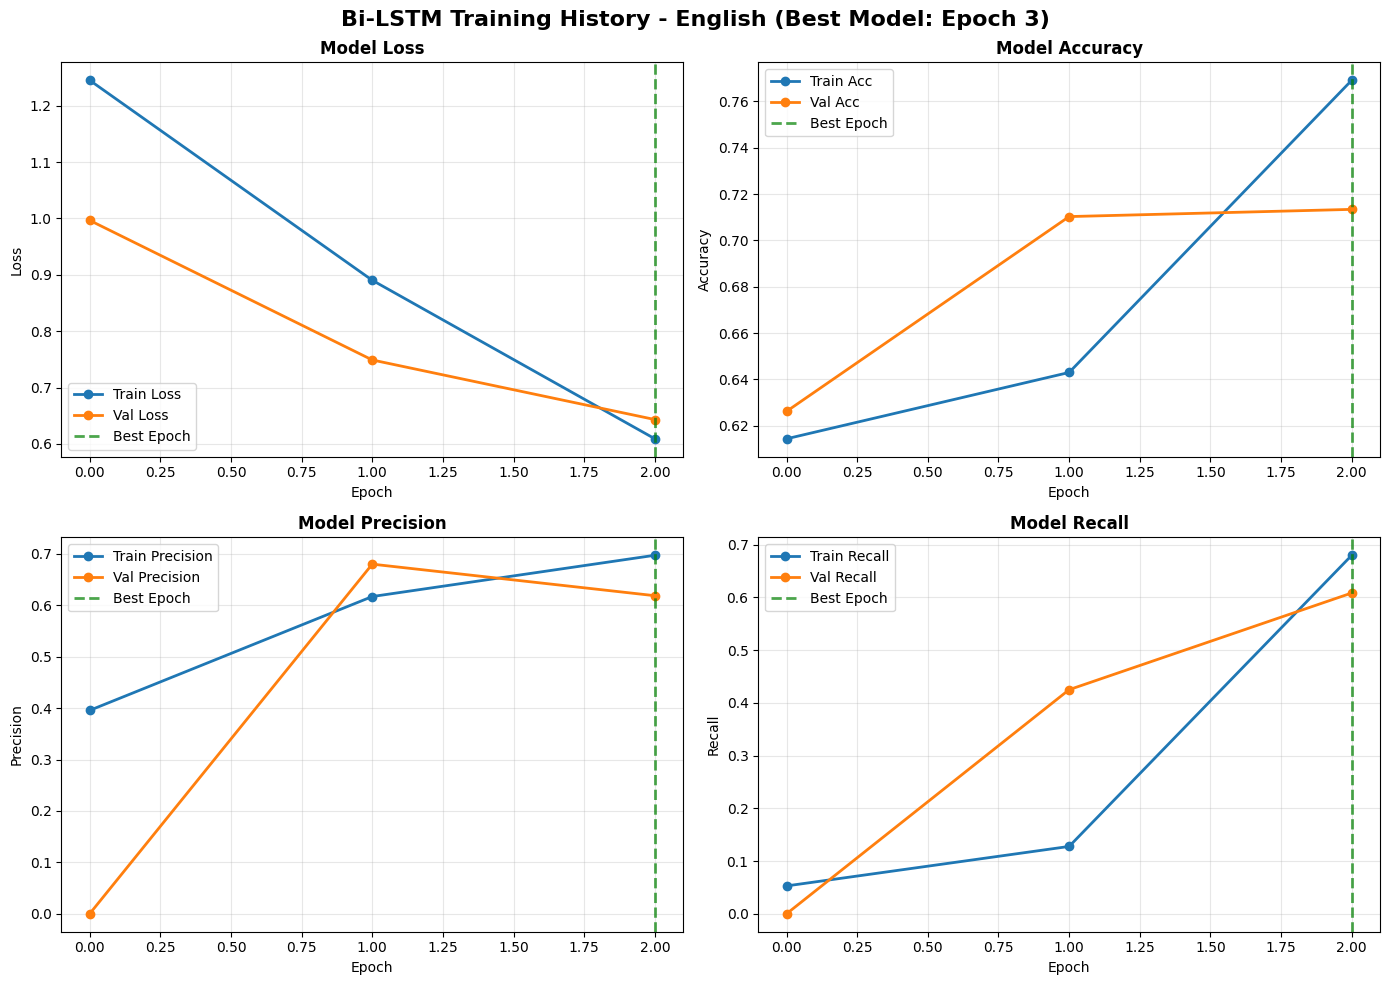

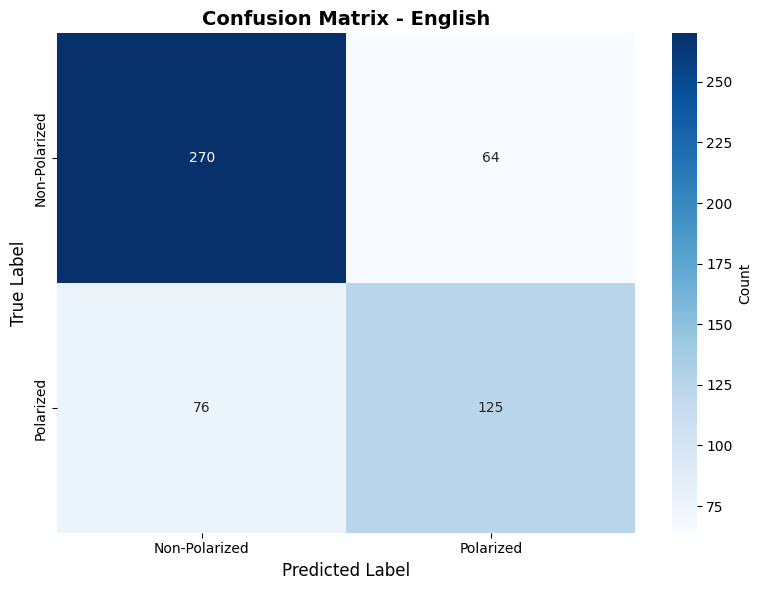


✓ Model and tokenizer saved for English

Completed English

############################################################
# Processing German Language
############################################################

Loading German data...
Train file: /content/data/deu_train.csv
Test file: /content/data/deu_test.csv
Successfully loaded with utf-8 encoding
Train samples: 2543
Test samples: 636
Columns: ['id', 'text', 'label']

Train label distribution:
label
0    1334
1    1209
Name: count, dtype: int64

Test label distribution:
label
0    334
1    302
Name: count, dtype: int64

Tokenizing German text...
Vocabulary size: 8606
Train sequences shape: (2543, 50)
Test sequences shape: (636, 50)

Data split:
Train: 2161
Validation: 382
Test: 636

Model Architecture:


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_8 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_9 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)


Training German model...
Epoch 1/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 575ms/step - accuracy: 0.5405 - loss: 1.3719 - precision_4: 0.5503 - recall_4: 0.2854
Epoch 1: val_loss improved from inf to 0.97664, saving model to /content/models/bilstm_deu_best.h5


68/68 ━━━━━━━━━━━━━━━━━━━━ 54s 622ms/step - accuracy: 0.5404 - loss: 1.3697 - precision_4: 0.5497 - recall_4: 0.2850 - val_accuracy: 0.5236 - val_loss: 0.9766 - val_precision_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 573ms/step - accuracy: 0.5072 - loss: 0.9177 - precision_4: 0.5041 - recall_4: 0.1778
Epoch 2: val_loss improved from 0.97664 to 0.79403, saving model to /content/models/bilstm_deu_best.h5


68/68 ━━━━━━━━━━━━━━━━━━━━ 40s 592ms/step - accuracy: 0.5073 - loss: 0.9171 - precision_4: 0.5037 - recall_4: 0.1793 - val_accuracy: 0.4503 - val_loss: 0.7940 - val_precision_4: 0.4462 - val_recall_4: 0.6374 - learning_rate: 0.0010
Epoch 3/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 569ms/step - accuracy: 0.5280 - loss: 0.7718 - precision_4: 0.4992 - recall_4: 0.2014
Epoch 3: val_loss improved from 0.79403 to 0.72381, saving model to /content/models/bilstm_deu_best.h5


68/68 ━━━━━━━━━━━━━━━━━━━━ 40s 587ms/step - accuracy: 0.5281 - loss: 0.7715 - precision_4: 0.4996 - recall_4: 0.2006 - val_accuracy: 0.5524 - val_loss: 0.7238 - val_precision_4: 0.5775 - val_recall_4: 0.2253 - learning_rate: 0.0010
Epoch 4/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 571ms/step - accuracy: 0.6401 - loss: 0.6939 - precision_4: 0.7428 - recall_4: 0.3712
Epoch 4: val_loss did not improve from 0.72381
68/68 ━━━━━━━━━━━━━━━━━━━━ 41s 596ms/step - accuracy: 0.6406 - loss: 0.6935 - precision_4: 0.7425 - recall_4: 0.3734 - val_accuracy: 0.5471 - val_loss: 0.7938 - val_precision_4: 0.5179 - val_recall_4: 0.7143 - learning_rate: 0.0010
Epoch 5/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 578ms/step - accuracy: 0.8139 - loss: 0.4832 - precision_4: 0.8192 - recall_4: 0.7738
Epoch 5: val_loss improved from 0.72381 to 0.69089, saving model to /content/models/bilstm_deu_best.h5


68/68 ━━━━━━━━━━━━━━━━━━━━ 41s 599ms/step - accuracy: 0.8139 - loss: 0.4830 - precision_4: 0.8193 - recall_4: 0.7737 - val_accuracy: 0.6440 - val_loss: 0.6909 - val_precision_4: 0.6307 - val_recall_4: 0.6099 - learning_rate: 0.0010
Epoch 6/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 669ms/step - accuracy: 0.9091 - loss: 0.2877 - precision_4: 0.8970 - recall_4: 0.9086
Epoch 6: val_loss did not improve from 0.69089
68/68 ━━━━━━━━━━━━━━━━━━━━ 48s 705ms/step - accuracy: 0.9091 - loss: 0.2874 - precision_4: 0.8971 - recall_4: 0.9085 - val_accuracy: 0.6440 - val_loss: 0.9660 - val_precision_4: 0.6292 - val_recall_4: 0.6154 - learning_rate: 0.0010
Epoch 7/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 714ms/step - accuracy: 0.9561 - loss: 0.1629 - precision_4: 0.9562 - recall_4: 0.9489
Epoch 7: val_loss did not improve from 0.69089

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
68/68 ━━━━━━━━━━━━━━━━━━━━ 85s 741ms/step - accuracy: 0.9559 - loss: 0.1634 - precision_4: 0.9560 - recall_4: 0

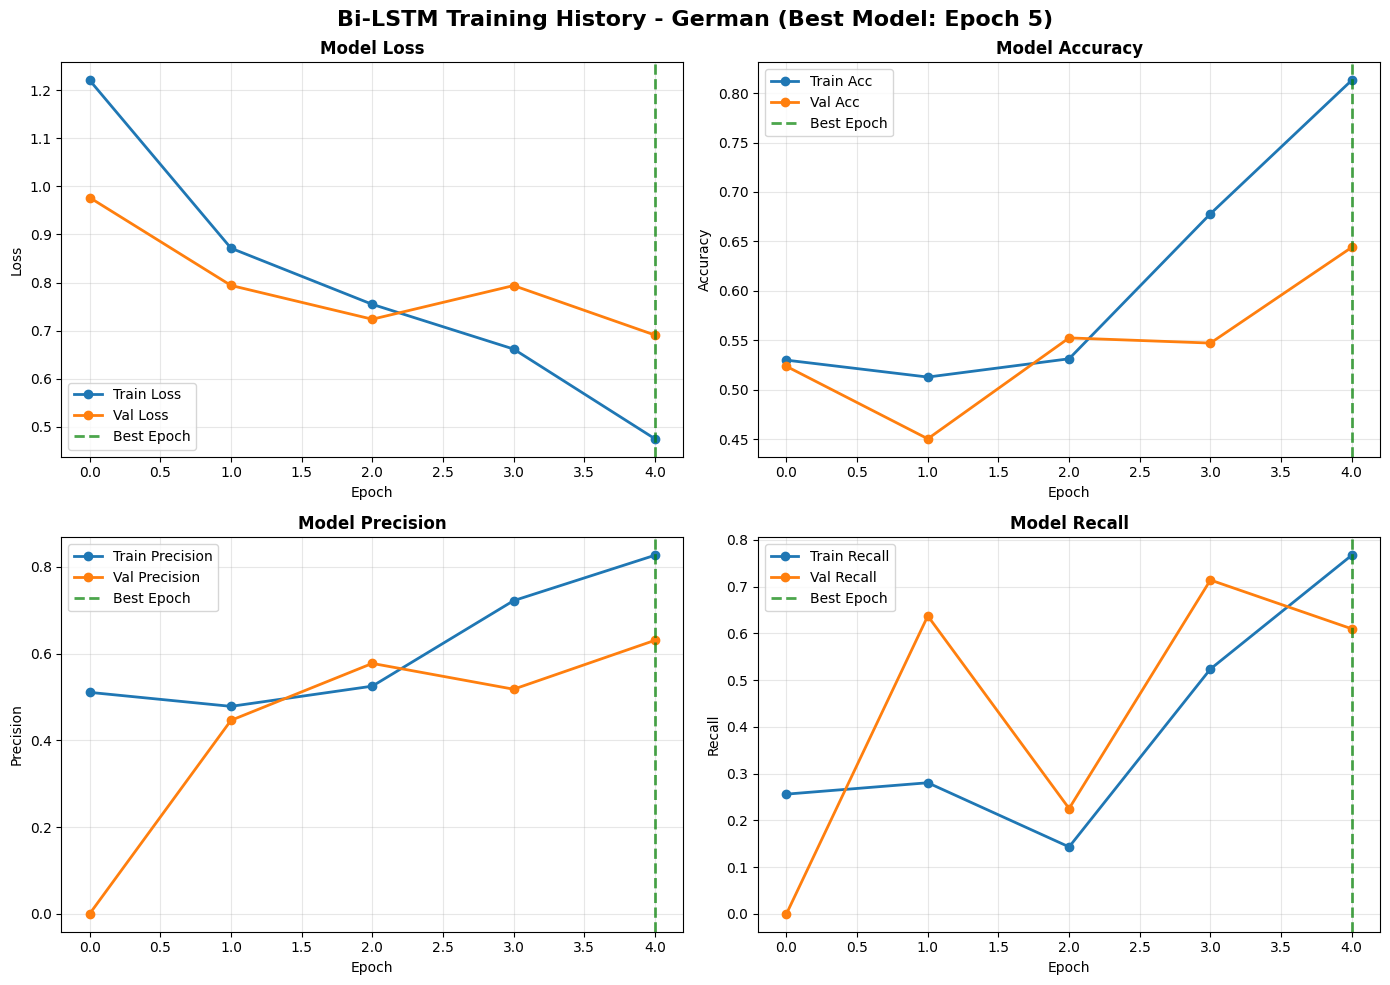

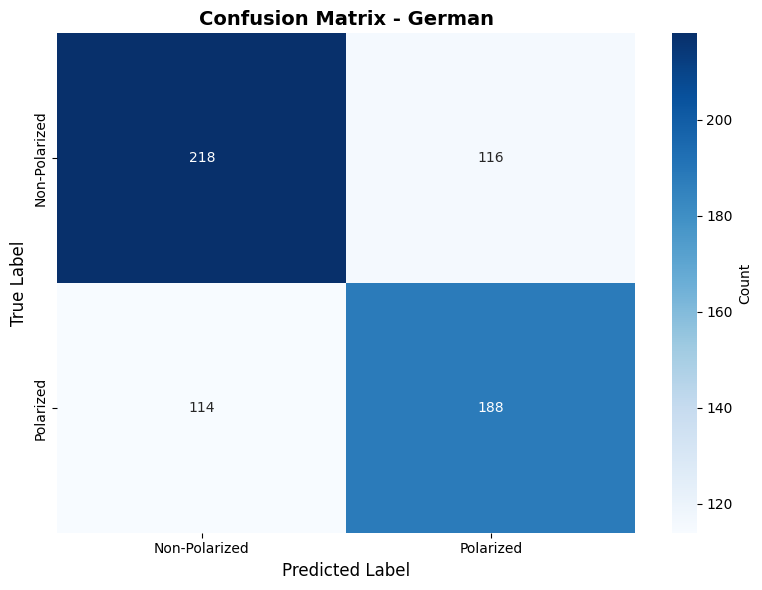


✓ Model and tokenizer saved for German

Completed German

############################################################
# Processing Spanish Language
############################################################

Loading Spanish data...
Train file: /content/data/spa_train.csv
Test file: /content/data/spa_test.csv
Successfully loaded with utf-8 encoding
Train samples: 2641
Test samples: 661
Columns: ['id', 'text', 'label']

Train label distribution:
label
1    1326
0    1315
Name: count, dtype: int64

Test label distribution:
label
1    332
0    329
Name: count, dtype: int64

Tokenizing Spanish text...
Vocabulary size: 6254
Train sequences shape: (2641, 50)
Test sequences shape: (661, 50)

Data split:
Train: 2244
Validation: 397
Test: 661

Model Architecture:


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_10                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_11                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)


Training Spanish model...
Epoch 1/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 576ms/step - accuracy: 0.4906 - loss: 1.3630 - precision_5: 0.5021 - recall_5: 0.7151
Epoch 1: val_loss improved from inf to 0.96243, saving model to /content/models/bilstm_spa_best.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 56s 617ms/step - accuracy: 0.4907 - loss: 1.3609 - precision_5: 0.5021 - recall_5: 0.7137 - val_accuracy: 0.4987 - val_loss: 0.9624 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 573ms/step - accuracy: 0.5035 - loss: 0.9035 - precision_5: 0.5138 - recall_5: 0.5939
Epoch 2: val_loss improved from 0.96243 to 0.77765, saving model to /content/models/bilstm_spa_best.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 42s 597ms/step - accuracy: 0.5034 - loss: 0.9029 - precision_5: 0.5136 - recall_5: 0.5931 - val_accuracy: 0.4987 - val_loss: 0.7777 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 576ms/step - accuracy: 0.5006 - loss: 0.7592 - precision_5: 0.5091 - recall_5: 0.2999
Epoch 3: val_loss improved from 0.77765 to 0.71717, saving model to /content/models/bilstm_spa_best.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 82s 603ms/step - accuracy: 0.5008 - loss: 0.7590 - precision_5: 0.5093 - recall_5: 0.3012 - val_accuracy: 0.5088 - val_loss: 0.7172 - val_precision_5: 1.0000 - val_recall_5: 0.0201 - learning_rate: 0.0010
Epoch 4/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 567ms/step - accuracy: 0.5868 - loss: 0.6993 - precision_5: 0.6326 - recall_5: 0.4719
Epoch 4: val_loss improved from 0.71717 to 0.66003, saving model to /content/models/bilstm_spa_best.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 42s 586ms/step - accuracy: 0.5874 - loss: 0.6989 - precision_5: 0.6327 - recall_5: 0.4736 - val_accuracy: 0.6650 - val_loss: 0.6600 - val_precision_5: 0.6422 - val_recall_5: 0.7487 - learning_rate: 0.0010
Epoch 5/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 571ms/step - accuracy: 0.8231 - loss: 0.4743 - precision_5: 0.8327 - recall_5: 0.8126
Epoch 5: val_loss improved from 0.66003 to 0.64927, saving model to /content/models/bilstm_spa_best.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 82s 590ms/step - accuracy: 0.8231 - loss: 0.4741 - precision_5: 0.8329 - recall_5: 0.8125 - val_accuracy: 0.7003 - val_loss: 0.6493 - val_precision_5: 0.6980 - val_recall_5: 0.7085 - learning_rate: 0.0010
Epoch 6/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 563ms/step - accuracy: 0.9265 - loss: 0.2534 - precision_5: 0.9235 - recall_5: 0.9269
Epoch 6: val_loss did not improve from 0.64927
71/71 ━━━━━━━━━━━━━━━━━━━━ 41s 581ms/step - accuracy: 0.9265 - loss: 0.2534 - precision_5: 0.9234 - recall_5: 0.9269 - val_accuracy: 0.6952 - val_loss: 0.8266 - val_precision_5: 0.7468 - val_recall_5: 0.5930 - learning_rate: 0.0010
Epoch 7/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 565ms/step - accuracy: 0.9548 - loss: 0.1794 - precision_5: 0.9558 - recall_5: 0.9552
Epoch 7: val_loss did not improve from 0.64927

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
71/71 ━━━━━━━━━━━━━━━━━━━━ 43s 602ms/step - accuracy: 0.9549 - loss: 0.1791 - precision_5: 0.9559 - recall_5: 0

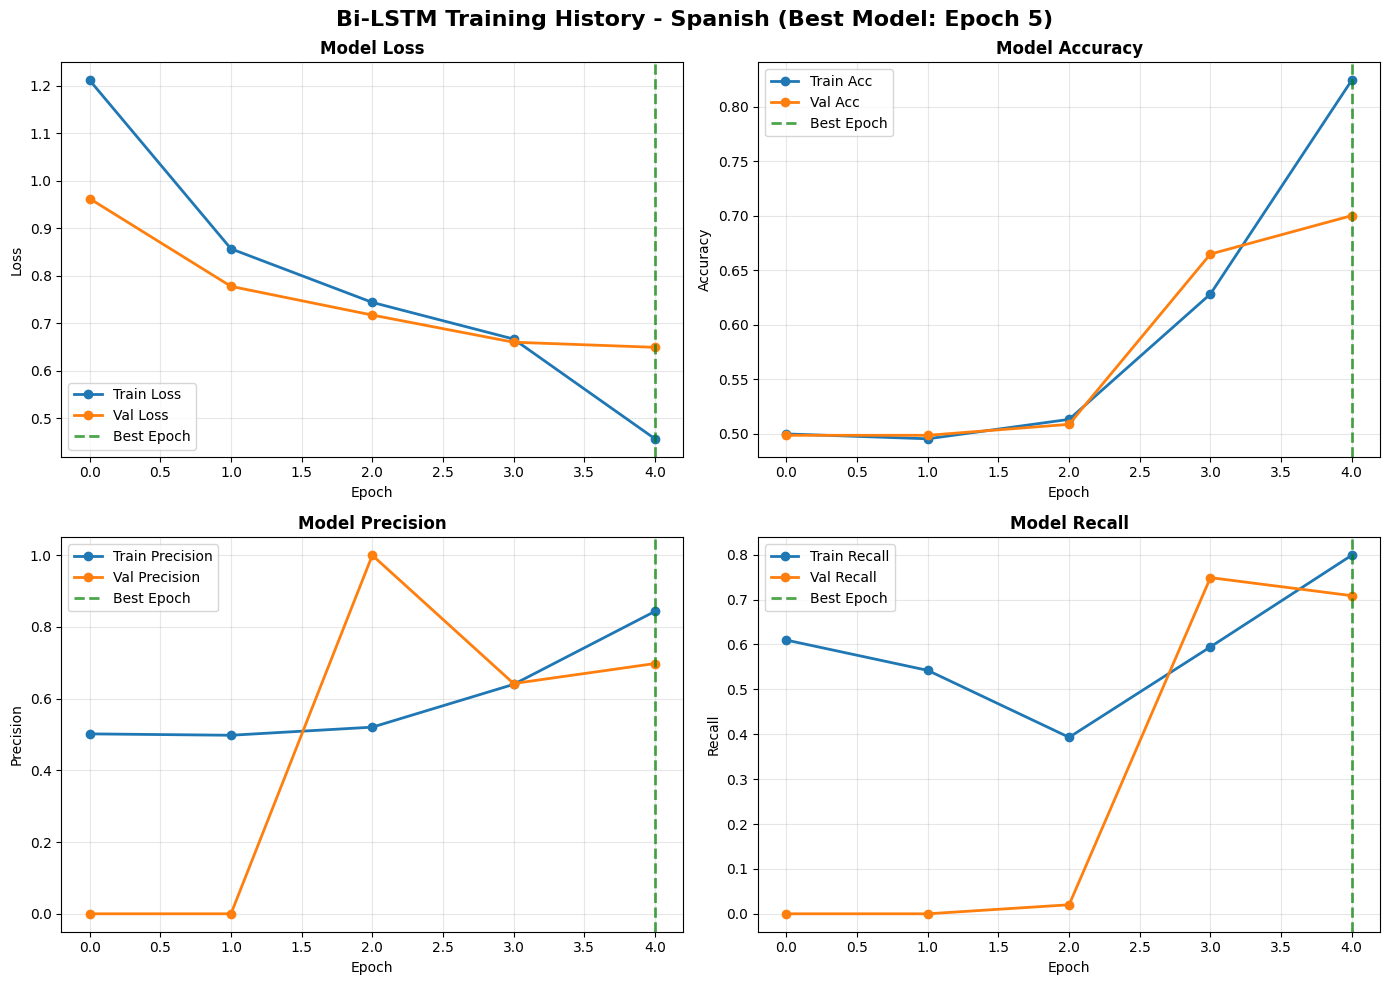

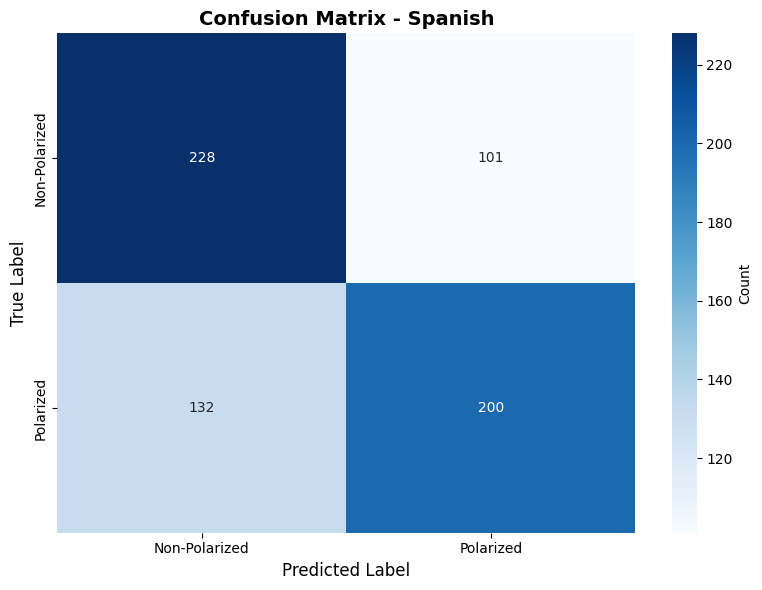


✓ Model and tokenizer saved for Spanish

Completed Spanish


In [70]:

all_results = {}
all_histories = {}

for lang in config.LANGUAGES:
    results, history = train_language_model(lang)
    all_results[lang] = results
    all_histories[lang] = history
    print(f"\nCompleted {config.LANGUAGE_NAMES[lang]}")
    print("="*60)

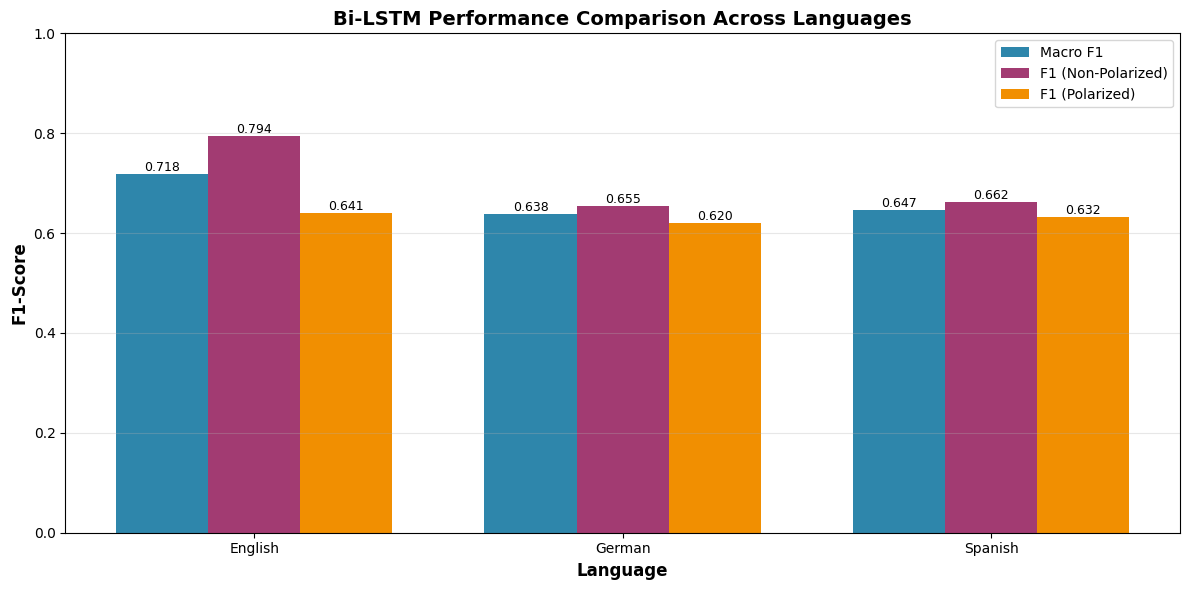

In [71]:

def plot_comparison():
    """Create comparison plots across all languages"""

    # Extract F1 scores
    languages = [config.LANGUAGE_NAMES[lang] for lang in config.LANGUAGES]
    f1_macros = [all_results[lang]['f1_macro'] for lang in config.LANGUAGES]
    f1_class0s = [all_results[lang]['f1_class0'] for lang in config.LANGUAGES]
    f1_class1s = [all_results[lang]['f1_class1'] for lang in config.LANGUAGES]

    # Create comparison plot
    fig, ax = plt.subplots(figsize=(12, 6))

    x = np.arange(len(languages))
    width = 0.25

    bars1 = ax.bar(x - width, f1_macros, width, label='Macro F1', color='#2E86AB')
    bars2 = ax.bar(x, f1_class0s, width, label='F1 (Non-Polarized)', color='#A23B72')
    bars3 = ax.bar(x + width, f1_class1s, width, label='F1 (Polarized)', color='#F18F01')

    ax.set_xlabel('Language', fontsize=12, fontweight='bold')
    ax.set_ylabel('F1-Score', fontsize=12, fontweight='bold')
    ax.set_title('Bi-LSTM Performance Comparison Across Languages',
                 fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(languages)
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3, axis='y')
    ax.set_ylim(0, 1.0)

    # Add value labels on bars
    for bars in [bars1, bars2, bars3]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.3f}',
                   ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    plt.savefig(f'{config.PLOTS_DIR}bilstm_comparison_all_languages.pdf',
                bbox_inches='tight', dpi=300)
    plt.show()

plot_comparison()


In [72]:
print("\n" + "="*60)
print("FINAL SUMMARY - Bi-LSTM BASELINE")
print("="*60)

for lang in config.LANGUAGES:
    lang_name = config.LANGUAGE_NAMES[lang]
    f1 = all_results[lang]['f1_macro']
    print(f"\n{lang_name}:")
    print(f"  Macro F1-Score: {f1:.4f}")
    print(f"  F1 (Non-Polarized): {all_results[lang]['f1_class0']:.4f}")
    print(f"  F1 (Polarized): {all_results[lang]['f1_class1']:.4f}")

print("\n" + "="*60)
print("All models trained and evaluated successfully!")
print(f"Results saved in: {config.RESULTS_DIR}")
print(f"Plots saved in: {config.PLOTS_DIR}")
print(f"Models saved in: {config.MODELS_DIR}")
print("="*60)


FINAL SUMMARY - Bi-LSTM BASELINE

English:
  Macro F1-Score: 0.7176
  F1 (Non-Polarized): 0.7941
  F1 (Polarized): 0.6410

German:
  Macro F1-Score: 0.6376
  F1 (Non-Polarized): 0.6547
  F1 (Polarized): 0.6205

Spanish:
  Macro F1-Score: 0.6469
  F1 (Non-Polarized): 0.6618
  F1 (Polarized): 0.6319

All models trained and evaluated successfully!
Results saved in: /content/results/
Plots saved in: /content/plots/
Models saved in: /content/models/
